<a href="https://colab.research.google.com/github/hawa1983/DATA-602/blob/main/DATA_608_HW2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-85-d1055a585418>:17: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

<ipython-input-85-d1055a585418>:25: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



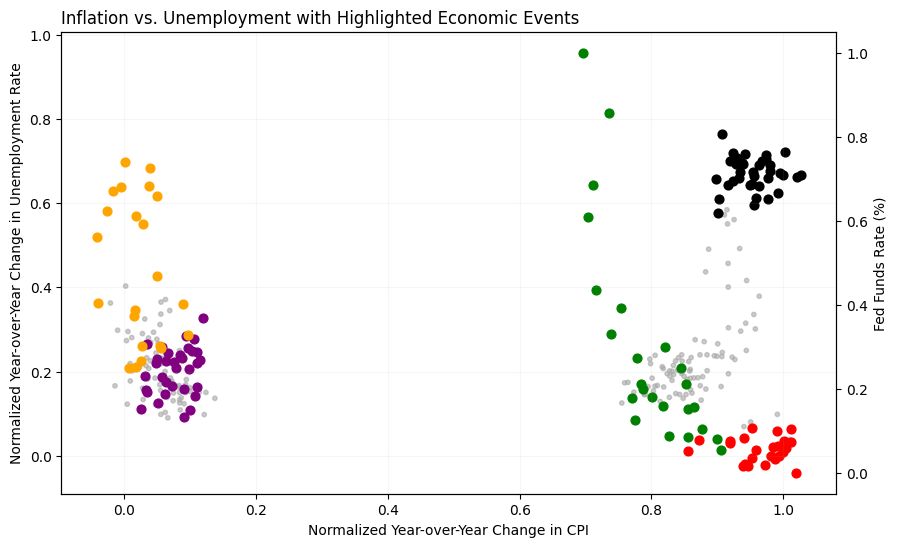

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the datasets
cpi_df = pd.read_csv('CPI_not_seasonally_adjusted.csv')
fed_rate_df = pd.read_csv('FED_FUNDS_RATE.csv')
unemployment_df = pd.read_csv('Unemployment_rate.csv')

# Reshape CPI data to long format and handle special cases
cpi_long = pd.melt(cpi_df, id_vars='Year', var_name='Month', value_name='CPI')
cpi_long = cpi_long[~cpi_long['Month'].isin(['HALF1', 'HALF2'])]
cpi_long['Date'] = pd.to_datetime(cpi_long['Year'].astype(str) + '-' + cpi_long['Month'], format='%Y-%b')

# Calculate YoY percentage change for CPI
cpi_long['YoY_Change_CPI'] = cpi_long['CPI'].pct_change(12) * 100
cpi_long = cpi_long.dropna(subset=['YoY_Change_CPI'])

# Reshape Unemployment data to long format
unemployment_long = pd.melt(unemployment_df, id_vars='Year', var_name='Month', value_name='Unemployment Rate')
unemployment_long['Date'] = pd.to_datetime(unemployment_long['Year'].astype(str) + '-' + unemployment_long['Month'], format='%Y-%b')

# Calculate YoY percentage change for Unemployment Rate
unemployment_long['YoY_Change_Unemployment'] = unemployment_long['Unemployment Rate'].pct_change(12) * 100
unemployment_long = unemployment_long.dropna(subset=['YoY_Change_Unemployment'])

# Convert the DATE column in fed_rate_df to datetime64[ns]
fed_rate_df['DATE'] = pd.to_datetime(fed_rate_df['DATE'])

# Merge datasets
merged_df = pd.merge(cpi_long[['Date', 'YoY_Change_CPI']], unemployment_long[['Date', 'YoY_Change_Unemployment']], on='Date')
merged_df = pd.merge(merged_df, fed_rate_df[['DATE', 'FEDFUNDS']], left_on='Date', right_on='DATE')
merged_df.drop(columns=['DATE'], inplace=True)
merged_df = merged_df.sort_values(by='Date')

# Normalize the YoY Change in CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Add jitter to the CPI and Unemployment values
jitter_strength = 0.05  # Adjust this value as needed
merged_df['YoY_Change_CPI_Jitter'] = merged_df['YoY_Change_CPI'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_df))
merged_df['YoY_Change_Unemployment_Jitter'] = merged_df['YoY_Change_Unemployment'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_df))

# Define periods of interest with distinct colors and labels with rate action description
highlight_periods = [
    ('2000-01-01', '2002-12-31', 'Dot-com Bubble (cut)', 'purple'),
    ('2008-01-01', '2009-12-31', 'Financial Crisis (cut)', 'orange'),
    ('2010-01-01', '2012-12-31', 'Great Recession Aftermath (maintain)', 'black'),
    ('2020-01-01', '2021-12-31', 'COVID-19 Pandemic (cut)', 'green'),
    ('2022-01-01', '2024-01-01', 'Inflation Surge (hike)', 'red')
]

# Assign a color to each data point based on the date range
merged_df['Event'] = 'Other Points'
merged_df['Color'] = 'darkgrey'

for start, end, event, color in highlight_periods:
    mask = (merged_df['Date'] >= pd.to_datetime(start)) & (merged_df['Date'] <= pd.to_datetime(end))
    merged_df.loc[mask, 'Event'] = event
    merged_df.loc[mask, 'Color'] = color

# Create the scatter plot with secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot all points with jittered values and smaller dots (s=20)
ax1.scatter(merged_df['YoY_Change_CPI_Jitter'], merged_df['YoY_Change_Unemployment_Jitter'],
            c=merged_df['Color'], alpha=0.6, label='Other Points', s=10)

# Plot highlighted events with jitter and smaller dots (s=40)
for event, color in [(event, color) for _, _, event, color in highlight_periods]:
    subset = merged_df[merged_df['Event'] == event]
    ax1.scatter(subset['YoY_Change_CPI_Jitter'], subset['YoY_Change_Unemployment_Jitter'], color=color, label=event, edgecolor=color, s=40)

# Add a secondary y-axis for Fed Funds Rate, but make the line invisible
ax2 = ax1.twinx()
ax2.plot(merged_df['YoY_Change_CPI'], merged_df['FEDFUNDS'], color='none', linewidth=1)
ax2.set_ylabel('Fed Funds Rate (%)')

# Customize the plot
ax1.set_title('Inflation vs. Unemployment with Highlighted Economic Events', loc='left')
ax1.set_xlabel('Normalized Year-over-Year Change in CPI')
ax1.set_ylabel('Normalized Year-over-Year Change in Unemployment Rate')
ax1.grid(True, alpha=0.1)  # Faint grid lines
# ax1.legend(title='Economic Events', loc='upper center', bbox_to_anchor=(0.40, 0.95))

plt.show()


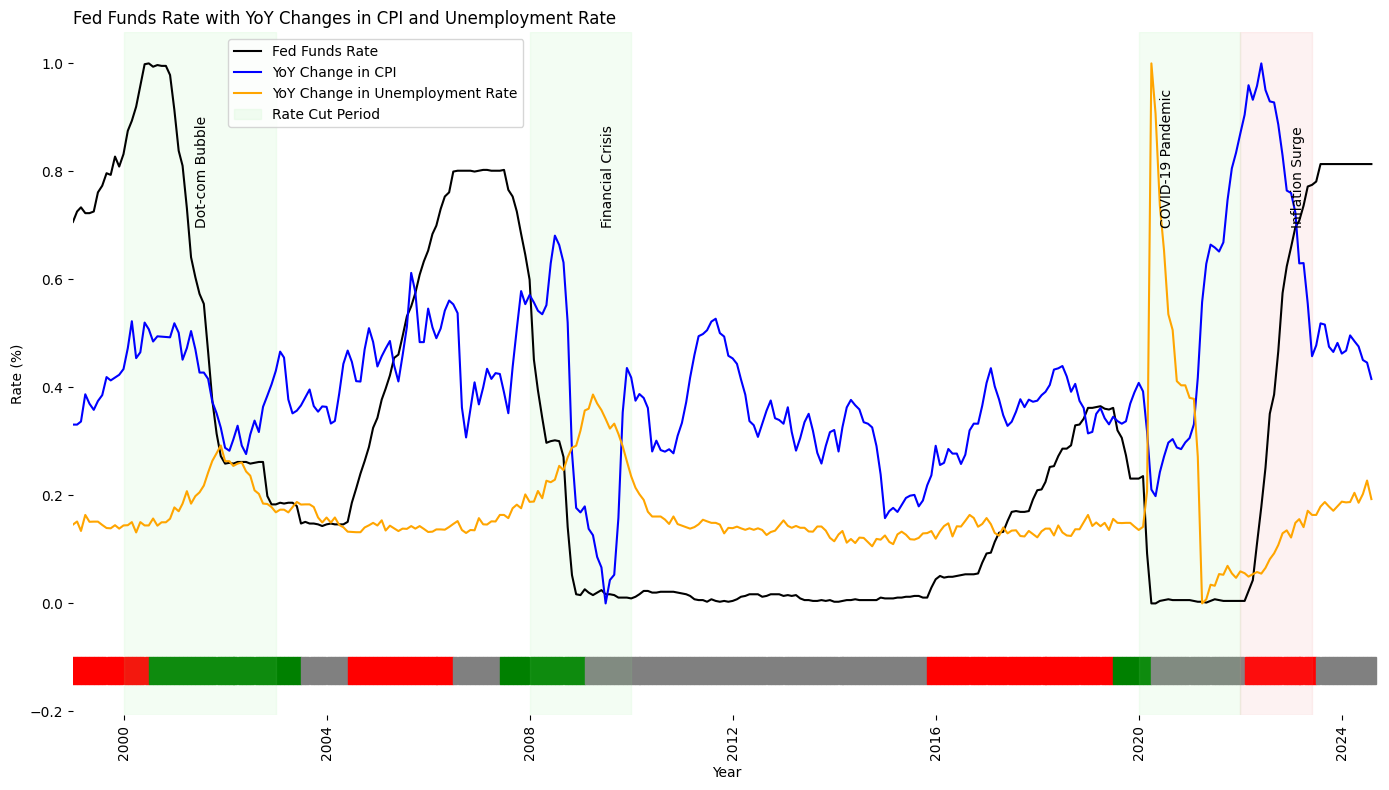

In [87]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates  # Import mdates for correct date formatting

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '1998-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to fetch data from FRED API
def fetch_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'])
        return df[['date', 'value']]
    else:
        raise Exception(f"Error fetching {series_id} data: {response.status_code}")

# Fetch CPI, Unemployment, and Fed Funds Rate data
cpi_data = fetch_fred_data('CPIAUCSL', api_key, start_date, end_date)
unemployment_data = fetch_fred_data('UNRATE', api_key, start_date, end_date)
fedfunds_data = fetch_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for easier handling
cpi_data.rename(columns={'value': 'CPI'}, inplace=True)
unemployment_data.rename(columns={'value': 'Unemployment_Rate'}, inplace=True)
fedfunds_data.rename(columns={'value': 'FEDFUNDS'}, inplace=True)

# Calculate YoY Percentage Change for CPI and Unemployment
cpi_data['YoY_Change_CPI'] = cpi_data['CPI'].pct_change(periods=12) * 100
unemployment_data['YoY_Change_Unemployment'] = unemployment_data['Unemployment_Rate'].pct_change(periods=12) * 100

# Merge the data
merged_df = pd.merge(cpi_data[['date', 'YoY_Change_CPI']], unemployment_data[['date', 'YoY_Change_Unemployment']], on='date')
merged_df = pd.merge(merged_df, fedfunds_data[['date', 'FEDFUNDS']], on='date')

# Normalize using Min-Max scaling
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Define color scheme based on time periods
def rate_color_map(date):
    if date >= pd.to_datetime("1999-01-01") and date <= pd.to_datetime("2000-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2000-06-01") and date <= pd.to_datetime("2003-06-01"):
        return 'green'
    elif date >= pd.to_datetime("2004-06-01") and date <= pd.to_datetime("2006-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2007-06-01") and date <= pd.to_datetime("2009-01-01"):
        return 'green'
    elif date >= pd.to_datetime("2015-11-01") and date <= pd.to_datetime("2019-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2019-07-01") and date <= pd.to_datetime("2020-03-01"):
        return 'green'
    elif date >= pd.to_datetime("2022-02-01") and date <= pd.to_datetime("2023-06-01"):
        return 'red'
    else:
        return 'grey'

# Apply color scheme to data
merged_df['RateCategory'] = merged_df['date'].apply(rate_color_map)

# Create the heatmap data
heatmap_data = merged_df[['date', 'RateCategory']]

# Create a larger bottom margin to accommodate the heatmap below the x-axis
plt.figure(figsize=(14, 8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for heatmap

# Plot the rate change heatmap as tiles on the bottom border of the plot (below x-axis)
for i in range(len(heatmap_data)):
    plt.gca().add_patch(
        plt.Rectangle(
            (heatmap_data.iloc[i]['date'], -0.15),  # Move heatmap below x-axis (-0.15)
            pd.Timedelta(days=30),  # Width in days
            0.05,  # Height of the heatmap tile
            color=heatmap_data.iloc[i]['RateCategory']
        )
    )

# Plot FEDFUNDS, YoY Change in CPI, and YoY Change in Unemployment
sns.lineplot(data=merged_df, x='date', y='FEDFUNDS', label='Fed Funds Rate', color='black')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_CPI', label='YoY Change in CPI', color='blue')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_Unemployment', label='YoY Change in Unemployment Rate', color='orange')

# Highlight periods with colored bands
plt.axvspan(pd.to_datetime("2000-01-01"), pd.to_datetime("2002-12-31"), color="lightgreen", alpha=0.1, label='Rate Cut Period')
plt.axvspan(pd.to_datetime("2008-01-01"), pd.to_datetime("2009-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2022-01-01"), pd.to_datetime("2023-06-01"), color="lightcoral", alpha=0.1)

# Add labels for significant periods
plt.text(pd.to_datetime("2001-06-01"), 0.7, "Dot-com Bubble", rotation=90)
plt.text(pd.to_datetime("2009-06-01"), 0.7, "Financial Crisis", rotation=90)
plt.text(pd.to_datetime("2020-06-01"), 0.7, "COVID-19 Pandemic", rotation=90)
plt.text(pd.to_datetime("2023-01-01"), 0.7, "Inflation Surge", rotation=90)

# Correctly format the x-axis to display years properly
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))  # Set ticks every 4 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks as years

# Set x-axis limits and labels
plt.xlim(pd.to_datetime("1999-01-01"), pd.to_datetime(end_date))
plt.xticks(rotation=90)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Fed Funds Rate with YoY Changes in CPI and Unemployment Rate', loc='left')

# Move the legend towards the left
plt.legend(loc='upper right', bbox_to_anchor=(0.35, 1))  # Moving the legend to the left

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()
